# Load Data

In [2]:
import tensorflow as tf

# Load the Fashion MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0

## Data Prep

In [3]:
# Subset your data the same 3 digit classes you used in the last assignments.

# Again, You can totally copy any code over and modify it.
# You can use chatGPT, copilot, google, or other AI or online resources.
# Use each other, the goal is to complete the objectives and maybe learn something new, not to struggle to make up code on your own.
# We have prior notebooks, chatGPT, the internet, and each other for the rapids projects, so use them here if they will help!

# Extract the 3 classes from the training data

train_filter = (y_train == 1) | (y_train == 7) | (y_train == 9)
x_train_179 = x_train[train_filter]
y_train_179 = y_train[train_filter]

# Extract the 3 classes from the test data

test_filter = (y_test == 1) | (y_test == 7) | (y_test == 9)
x_test_179 = x_test[test_filter]
y_test_179 = y_test[test_filter]

print(y_train_179)
y_train_79_bin = (y_train_179 == 7).astype(int) | (y_train_179 == 9).astype(int)
y_train_9_bin = (y_train_179 == 9).astype(int)
y_train_179_bin = y_train_79_bin + y_train_9_bin
y_test_79_bin = (y_test_179 == 7).astype(int) | (y_test_179 == 9).astype(int)
y_test_9_bin = (y_test_179 == 9).astype(int)
y_test_179_bin = y_test_79_bin + y_test_9_bin
print(y_train_179_bin)

[1 9 1 ... 9 9 1]
[0 2 0 ... 2 2 0]


## Plot Data

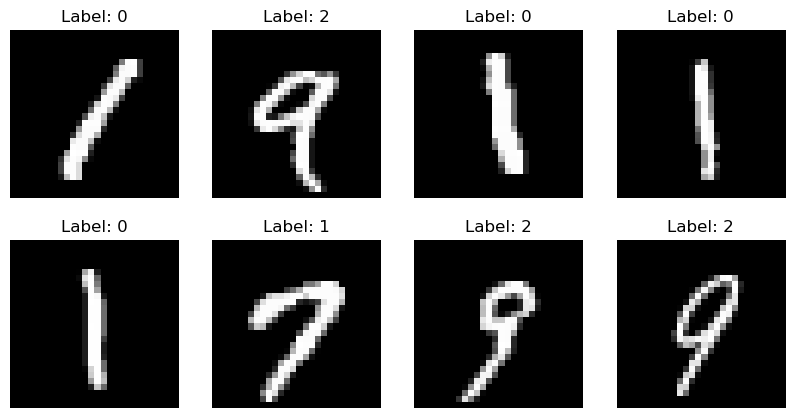

In [4]:
## Plot 6 to 10 images from your data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_train_179[i], cmap='gray')
    plt.title(f'Label: {y_train_179_bin[i]}')
    plt.axis('off')

plt.show()


# Transfer Learning

## Load and Modify Model

In [5]:
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Load and modify a pre-trained mobilenet_v2 model for your dataset
# Make sure to change the output layer for the number of classes you are using

# Load pre-trained MobileNetV2
model = mobilenet_v2(pretrained=True)

# Modify the input layer for grayscale (1 channel)
model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)

# Modify the output layer for your dataset's number of classes
model.classifier[1] = nn.Linear(model.last_channel, 3)

print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Modify Data to fit with Model

In [6]:
import torchvision.transforms as transforms
import torch

# Pre-trained models may not match the structure of our data.
# It's best to modify the model to handle the data, but we may need to adjust the images as well.
# Resize the images to 32x32 for the model

# Define the transform to resize the images
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

# Apply the transform to the training and test datasets
x_train_179_resized = torch.stack([resize_transform(img) for img in x_train_179])
x_test_179_resized = torch.stack([resize_transform(img) for img in x_test_179])

print(f'x_train_179_resized shape: {x_train_179_resized.shape}')
print(f'x_test_179_resized shape: {x_test_179_resized.shape}')


x_train_179_resized shape: torch.Size([18956, 1, 32, 32])
x_test_179_resized shape: torch.Size([3172, 1, 32, 32])


## Fit Model on our Data

In [8]:
import torch
from torchvision.models import mobilenet_v2
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim

# Create Tensors and DataLoader for resized training and testing data
y_train_tensor = torch.tensor(y_train_179_bin, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_179_bin, dtype=torch.long)

train_dataset_resized = TensorDataset(x_train_179_resized, y_train_tensor)
test_dataset_resized = TensorDataset(x_test_179_resized, y_test_tensor)
train_loader_resized = DataLoader(train_dataset_resized, batch_size=64, shuffle=True)
test_loader_resized = DataLoader(test_dataset_resized, batch_size=64, shuffle=False)

# Update your model with our training data
# Report some notion of accuracy, loss or both as it builds to see how well your model is doing.

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model on resized data
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_resized:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    #print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader_resized)}')

# Evaluate the model on resized test data
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader_resized:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader_resized)
    avg_val_loss = val_loss / len(test_loader_resized)
    val_accuracy = correct / total
        
    # Print metrics rounded to 4 decimals
    print(f'Epoch {epoch + 1}/{num_epochs}, '
        f'Train Loss: {avg_train_loss:.4f}, '
        f'Validation Loss: {avg_val_loss:.4f}, '
        f'Validation Accuracy: {val_accuracy:.4f}')

print(f'Test Accuracy on resized data: {100 * correct / total}%')

Epoch 1/10, Train Loss: 0.0587, Validation Loss: 0.0308, Validation Accuracy: 0.9931
Epoch 2/10, Train Loss: 0.0260, Validation Loss: 0.0093, Validation Accuracy: 0.9975
Epoch 3/10, Train Loss: 0.0228, Validation Loss: 0.0064, Validation Accuracy: 0.9978
Epoch 4/10, Train Loss: 0.0138, Validation Loss: 0.0048, Validation Accuracy: 0.9981
Epoch 5/10, Train Loss: 0.0179, Validation Loss: 0.0144, Validation Accuracy: 0.9956
Epoch 6/10, Train Loss: 0.0140, Validation Loss: 0.0075, Validation Accuracy: 0.9981
Epoch 7/10, Train Loss: 0.0135, Validation Loss: 0.0131, Validation Accuracy: 0.9950
Epoch 8/10, Train Loss: 0.0082, Validation Loss: 0.0353, Validation Accuracy: 0.9934
Epoch 9/10, Train Loss: 0.0081, Validation Loss: 0.0085, Validation Accuracy: 0.9965
Epoch 10/10, Train Loss: 0.0135, Validation Loss: 0.0156, Validation Accuracy: 0.9962
Test Accuracy on resized data: 99.62168978562421%


## Confusion Matrix

[1 0 0 ... 1 2 0]


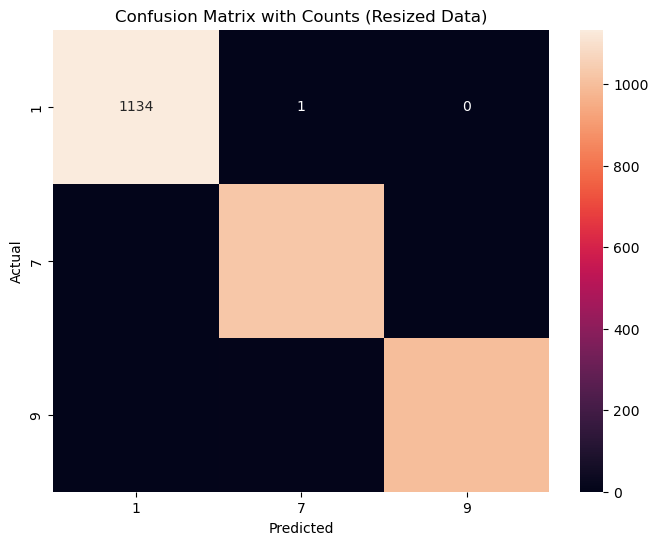

In [9]:
# Compute and plot a confusion matrix.

from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Make predictions on the resized test set
with torch.no_grad():
    outputs_resized = model(x_test_179_resized)
    _, predicted_resized = torch.max(outputs_resized, 1)

# Convert predictions to numpy array
predicted_resized = predicted_resized.numpy()

print(predicted_resized)

# Compute the confusion matrix
conf_matrix_resized = confusion_matrix(y_test_179_bin, predicted_resized)

# Plot the confusion matrix with counts
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_resized, annot=True, fmt='d', xticklabels=[1, 7, 9], yticklabels=[1, 7, 9])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Counts (Resized Data)')
plt.show()

# Where are misclassifications occurring?
# How does your test accuracy compare to that of the Random Forest and CNN made previously?
# It's very possible that it won't be better than the CNN.
# This hopefully illustrates the importance of choosing the right kind of model to transfer learn from.

## Plot Misclassifications

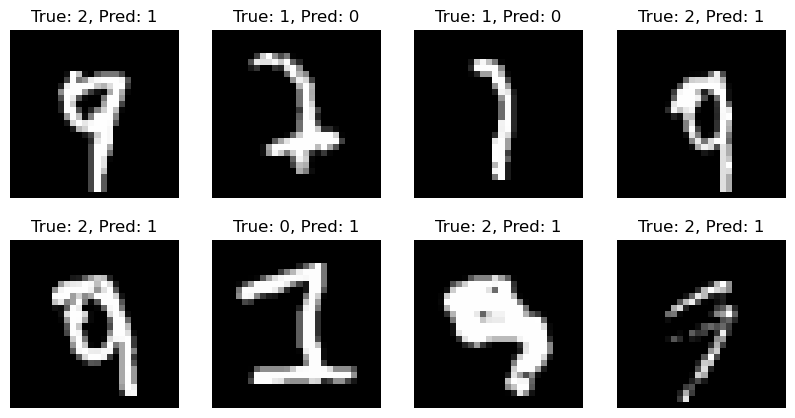

In [10]:
# Plot some of the misclassifications.

import matplotlib.pyplot as plt

# Find misclassified examples
misclassified_indices = (predicted_resized != y_test_179_bin).nonzero()[0]

# Plot some misclassified examples
plt.figure(figsize=(10, 5))

for i, idx in enumerate(misclassified_indices[:8]):
    plt.subplot(2, 4, i + 1)
    plt.imshow(x_test_179[idx], cmap='gray')
    plt.title(f'True: {y_test_179_bin[idx]}, Pred: {predicted_resized[idx]}')
    plt.axis('off')

plt.show()

# Can you see why the model made the misclassifications it did?